## Overfitting Exercise
In this exercise, we'll build a model that, as you'll see, dramatically overfits the training data. This will allow you to see what overfitting can "look like" in practice.

In [1]:
import os
import pandas as pd 
import numpy as np 
import math
import matplotlib.pyplot as plt

For this exercise, we'll use gradient boosted trees. In order to implement this model, we'll use the XGBoost package.

In [2]:
! pip install xgboost

    100% |████████████████████████████████| 114.0MB 3.9kB/s eta 0:00:01 2% |▊                               | 2.5MB 34.0MB/s eta 0:00:04    8% |██▊                             | 9.9MB 31.8MB/s eta 0:00:04    9% |███▏                            | 11.4MB 34.2MB/s eta 0:00:04    13% |████▍                           | 15.7MB 28.9MB/s eta 0:00:04    20% |██████▊                         | 23.8MB 28.9MB/s eta 0:00:04    23% |███████▍                        | 26.4MB 29.6MB/s eta 0:00:03    25% |████████▏                       | 29.0MB 26.7MB/s eta 0:00:04    27% |████████▉                       | 31.6MB 27.8MB/s eta 0:00:03    29% |█████████▌                      | 34.0MB 24.3MB/s eta 0:00:04    30% |██████████                      | 35.3MB 18.3MB/s eta 0:00:05    32% |██████████▎                     | 36.5MB 26.4MB/s eta 0:00:03    43% |██████████████                  | 50.0MB 24.9MB/s eta 0:00:03    52% |████████████████▋               | 59.4MB 23.5MB/s eta 0:00:03    57% |██████████████████

In [3]:
import xgboost as xgb

Here, we define a few helper functions.

In [4]:
# number of rows in a dataframe
def nrow(df): 
    return(len(df.index))

# number of columns in a dataframe
def ncol(df): 
    return(len(df.columns))

# flatten nested lists/arrays
flatten = lambda l: [item for sublist in l for item in sublist]

# combine multiple arrays into a single list
def c(*args):
    return(flatten([item for item in args]))

In this exercise, we're going to try to predict the returns of the S&P 500 ETF. This may be a futile endeavor, since many experts consider the S&P 500 to be essentially unpredictable, but it will serve well for the purpose of this exercise. The following cell loads the data.

In [5]:
df = pd.read_csv("SPYZ.csv")

As you can see, the data file has four columns, `Date`, `Close`, `Volume` and `Return`.

In [6]:
df.head()

,Date,Close,Volume,Return
0,1999-12-31,146.8750,3172700,0.001598
1,2000-01-03,145.4375,8164300,-0.009787
2,2000-01-04,139.7500,8089800,-0.039106
3,2000-01-05,140.0000,12177900,0.001789
4,2000-01-06,137.7500,6227200,-0.016071


In [7]:
n = nrow(df)

Next, we'll form our predictors/features. In the cells below, we create four types of features. We also use a parameter, `K`, to set the number of each type of feature to build. With a `K` of 25, 100 features will be created. This should already seem like a lot of features, and alert you to the potential that the model will be overfit.

In [8]:
predictors = []

# we'll create a new DataFrame to hold the data that we'll use to train the model
# we'll create it from the `Return` column in the original DataFrame, but rename that column `y`
model_df = pd.DataFrame(data = df['Return']).rename(columns = {"Return" : "y"})

# IMPORTANT: this sets how many of each of the following four predictors to create
K = 25

Now, you write the code to create the four types of predictors.

In [11]:
for L in range(1,K+1): 
    # this predictor is just the return L days ago, where L goes from 1 to K
    # these predictors will be named `R1`, `R2`, etc.
    pR = "".join(["R",str(L)]) 
    predictors.append(pR)
    for i in range(K+1,n): 
        # TODO: fill in the code to assign the return from L days before to the ith row of this predictor in `model_df`
        model_df.loc[i, pR] = df.loc[i-L,'Return']

    # this predictor is the return L days ago, squared, where L goes from 1 to K
    # these predictors will be named `Rsq1`, `Rsq2`, etc.
    pR2 = "".join(["Rsq",str(L)])
    predictors.append(pR2)
    for i in range(K+1,n): 
        # TODO: fill in the code to assign the squared return from L days before to the ith row of this predictor 
        # in `model_df`
        model_df.loc[i, pR2] = (df.loc[i-L,'Return']) ** 2

    # this predictor is the log volume L days ago, where L goes from 1 to K
    # these predictors will be named `V1`, `V2`, etc.
    pV = "".join(["V",str(L)])
    predictors.append(pV)
    for i in range(K+1,n): 
        # TODO: fill in the code to assign the log of the volume from L days before to the ith row of this predictor 
        # in `model_df`
        # Add 1 to the volume before taking the log
        model_df.loc[i, pV] = math.log(1.0 + df.loc[i-L,'Volume'])

    # this predictor is the product of the return and the log volume from L days ago, where L goes from 1 to K
    # these predictors will be named `RV1`, `RV2`, etc.
    pRV = "".join(["RV",str(L)])
    predictors.append(pRV)
    for i in range(K+1,n): 
        # TODO: fill in the code to assign the product of the return and the log volume from L days before to the
        # ith row of this predictor in `model_df`
        model_df.loc[i, pRV] = model_df.loc[i, pR] * model_df.loc[i, pV]

Let's take a look at the predictors we've created.

In [12]:
model_df.iloc[100:105,:]

,y,R1,Rsq1,V1,RV1,R2,Rsq2,V2,RV2,R3,...,V23,RV23,R24,Rsq24,V24,RV24,R25,Rsq25,V25,RV25
100,0.016304,-0.014726,0.000217,15.892349,-0.234024,-0.007529,0.000057,16.198698,-0.121956,-0.018688,...,15.959991,0.076664,-0.009302,0.000087,15.695540,-0.145995,0.026421,0.000698,16.209371,0.428273
101,-0.017157,0.016304,0.000266,16.221058,0.264474,-0.014726,0.000217,15.892349,-0.234024,-0.007529,...,16.372203,-0.177882,0.004804,0.000023,15.959991,0.076664,-0.009302,0.000087,15.695540,-0.145995
102,0.001133,-0.017157,0.000294,15.929221,-0.273290,0.016304,0.000266,16.221058,0.264474,-0.014726,...,16.461827,0.683503,-0.010865,0.000118,16.372203,-0.177882,0.004804,0.000023,15.959991,0.076664
103,0.034194,0.001133,0.000001,15.387039,0.017437,-0.017157,0.000294,15.929221,-0.273290,0.016304,...,15.858172,-0.178954,0.041520,0.001724,16.461827,0.683503,-0.010865,0.000118,16.372203,-0.177882
104,0.000657,0.034194,0.001169,15.494960,0.529838,0.001133,0.000001,15.387039,0.017437,-0.017157,...,16.562480,-0.054770,-0.011285,0.000127,15.858172,-0.178954,0.041520,0.001724,16.461827,0.683503


Next, we create a DataFrame that holds the recent volatility of the ETF's returns, as measured by the standard deviation of a sliding window of the past 20 days' returns.

In [14]:
vol_df = pd.DataFrame(data = df[['Return']])

for i in range(K+1,n): 
    # TODO: create the code to assign the standard deviation of the return from the time period starting 
    # 20 days before day i, up to the day before day i, to the ith row of `vol_df`
    vol_df.loc[i, 'vol'] = np.std(vol_df.loc[(i-20):(i-1),'Return'])

Let's take a quick look at the result.

In [15]:
vol_df.iloc[100:105,:]

,Return,vol
100,0.016304,0.013069
101,-0.017157,0.013615
102,0.001133,0.014007
103,0.034194,0.014008
104,0.000657,0.015792


Now that we have our data, we can start thinking about training a model.

In [16]:
# for training, we'll use all the data except for the first K days, for which the predictors' values are NaNs
model = model_df.iloc[K:n,:]

In the cell below, first split the data into train and test sets, and then split off the targets from the predictors.

In [17]:
# Split data into train and test sets
train_size = 2.0/3.0
breakpoint = round(nrow(model) * train_size)

# TODO: fill in the code to split off the chunk of data up to the breakpoint as the training set, and
# assign the rest as the test set.
training_data = model.iloc[1:breakpoint,:]
test_data = model.loc[breakpoint : nrow(model),]

# TODO: Split training data and test data into targets (Y) and predictors (X), for the training set and the test set
X_train = training_data.iloc[:,1:ncol(training_data)]
Y_train = training_data.iloc[:,0]
X_test = test_data.iloc[:,1:ncol(training_data)]
Y_test = test_data.iloc[:,0]

Great, now that we have our data, let's train the model.

In [18]:
# DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency 
# and training speed. 
dtrain = xgb.DMatrix(X_train, Y_train)

# Train the XGBoost model
param = { 'max_depth':20, 'silent':1 }
num_round = 20
xgModel = xgb.train(param, dtrain, num_round)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Now let's predict the returns for the S&P 500 ETF in both the train and test periods. If the model is successful, what should the train and test accuracies look like? What would be a key sign that the model has overfit the training data?

Todo: Before you run the next cell, write down what you expect to see if the model is overfit.

In [19]:
# Make the predictions on the test data
preds_train = xgModel.predict(xgb.DMatrix(X_train))
preds_test = xgModel.predict(xgb.DMatrix(X_test))

Let's quickly look at the mean squared error of the predictions on the training and testing sets.

In [20]:
# TODO: Calculate the mean squared error on the training set
msetrain = sum((preds_train-Y_train)**2)/len(preds_train)
msetrain

1.6237099209080407e-06

In [21]:
# TODO: Calculate the mean squared error on the test set
msetest = sum((preds_test-Y_test)**2)/len(preds_test)
msetest

7.711855498216044e-05

Looks like the mean squared error on the test set is an order of magnitude greater than on the training set. Not a good sign. Now let's do some quick calculations to gauge how this would translate into performance. 

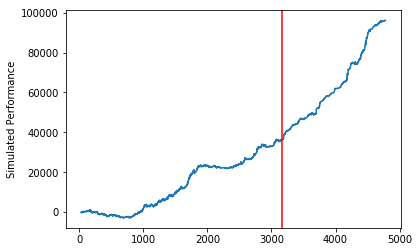

In [22]:
# combine prediction arrays into a single list
predictions = c(preds_train, preds_test)
responses = c(Y_train, Y_test)

# as a holding size, we'll take predicted return divided by return variance
# this is mean-variance optimization with a single asset
vols = vol_df.loc[K:n,'vol']
position_size = predictions / vols ** 2

# TODO: Calculate pnl. Pnl in each time period is holding * realized return.
performance = position_size + responses

# plot simulated performance
plt.plot(np.cumsum(performance))
plt.ylabel('Simulated Performance')
plt.axvline(x=breakpoint, c = 'r')
plt.show()

Our simulated returns accumulate throughout the training period, but they are absolutely flat in the testing period. The model has no predictive power whatsoever in the out-of-sample period.

Can you think of a few reasons our simulation of performance is unrealistic?

In [ ]:
# TODO: Answer the above question.

1.We left out any accounting of trading costs. If we had included trading costs, the performance in the out-of-sample period would be downward!

2.We didn't account for any time for trading. It's most conservative to assume that we would make trades on the day following our calculation of position size to take, and realize returns the day after that, such that there's a two-day delay between holding size calculation and realized return.